In [1]:
import os
import xarray as xr

from run_gom_mp import * 
from parcels import plotTrajectoriesFile

from copy import copy
from scipy import interpolate
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from copy import copy

from matplotlib import pyplot as plt, colors
_ = plt.ion()  # To trigger the interactive inline mode

In [13]:
#Set Up
indices = {'lon': range(ti_lonmin, ti_lonmax), 'lat': range(ti_latmin, ti_latmax)} # for testing
outfolder = 'testing_output/'

def clear_file(data_name):
    try:
        os.remove(data_name)
        print("Done Deleting")
    except OSError:
        pass

In [2]:
# Correct Plotting
gom_masks = xr.open_dataset('data/gom_masks.nc')

# Velocity nodes
lon_vals, lat_vals = np.meshgrid(gom_masks['Longitude'], gom_masks['Latitude'])
lons_plot = lon_vals[ti_latmin:ti_latmax,ti_lonmin:ti_lonmax]
lats_plot = lat_vals[ti_latmin:ti_latmax,ti_lonmin:ti_lonmax]

landmask = gom_masks.landmask

# Centers of the gridcells formed by 4 nodes = velocity nodes + 0.5 dx
x = gom_masks['Longitude'][:-1]+np.diff(gom_masks['Longitude'])/2
y = gom_masks['Latitude'][:-1]+np.diff(gom_masks['Latitude'])/2
lon_centers, lat_centers = np.meshgrid(x, y)

# Interpolate the landmask to the cell centers - only cells with 4 neighbouring land points will be land
fl = interpolate.interp2d(gom_masks['Longitude'],gom_masks['Latitude'],landmask)
l_centers = fl(lon_centers[0,:],lat_centers[:,0])  
lmask = np.ma.masked_values(l_centers,1) # land when interpolated value == 1
    
def quick_display_parcels(title = 'No Title'):
    fig = plt.figure(figsize=(6,6), constrained_layout=True)
    ax0 = fig.add_subplot()
    ax0.set_ylabel('Latitude [degrees]')
    ax0.set_xlabel('Longitude [degrees]')
    ax0.set_title(title, fontsize=14, fontweight = 'bold')

    land = ax0.pcolormesh(lon_vals[ti_latmin:ti_latmax+1,ti_lonmin:ti_lonmax+1], lat_vals[ti_latmin:ti_latmax+1,ti_lonmin:ti_lonmax+1], lmask.mask[ti_latmin:ti_latmax,ti_lonmin:ti_lonmax],cmap='Reds_r')
    ax0.scatter(lons_plot, lats_plot, c=landmask[ti_latmin:ti_latmax,ti_lonmin:ti_lonmax],s=25,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')
    return ax0

c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
DLL load failed while importing _version: The specified procedure could not be found.
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


#### Particle Release
Notes:
* Particles are generated uniformly within a circle of radius equal to CELL_SIZE = 0.04
* Blue point is a river release location
* Yellow point is a check of CELL_SIZE (was used for checking the distance to the boundry)
* All simulations use these release locations

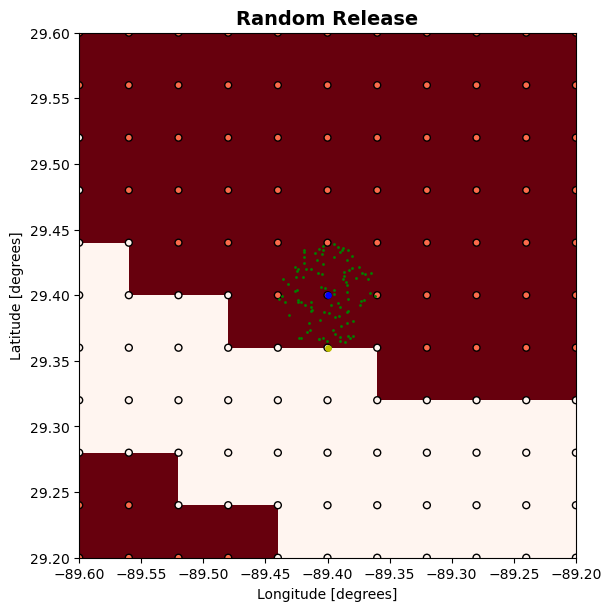

In [34]:
rand_lons, rand_lats = monte_carlo_particle_release(tc_lat, tc_lon, 100)
axr = quick_display_parcels('Random Release')
axr.set_xlim(-89.6, -89.2)
axr.set_ylim(29.2, 29.6)
releases = axr.scatter(rand_lons, rand_lats, c = 'g', s=1, zorder=1)
center = axr.scatter(tc_lon, tc_lat, c = 'b', s=15, zorder=2)
center_below = axr.scatter(tc_lon, tc_lat - CELL_SIZE, c = 'y', s=15, zorder=2)

#### 0. Baseline Simulation (ocean velocity, ~~displacement~~, ~~stokes~~, ~~diffusion~~)

In [3]:
file_000 = outfolder + 'testing_000.zarr'
clear_file(file_000)
_, _ = run_gom_mp(file_000, disp =False, stokes=False, diff = 0.0, indices=indices, testing=True)

c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
DLL load failed while importing _version: The specified procedure could not be found.
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
INFO: Compiled ArrayPlasticParticleAdvectionRK4 ==> C:\Users\pojun\AppData\Local\Temp\parcels-tmp\lib34c73b6c7212eac6e76b7d7471998487_0.dll
INFO: Output files are stored in testing_output/testing_000.zarr.
100%|██████████| 1800000.0/1800000.0 [01:07<00:00, 26789.84it/s]        


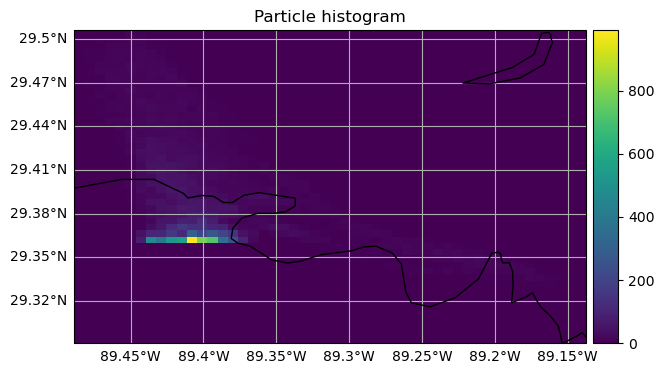

<module 'matplotlib.pyplot' from 'c:\\Users\\pojun\\anaconda3\\envs\\py3_parcels\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [31]:
plotTrajectoriesFile(file_000, mode='hist2d', bins = 50)

c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


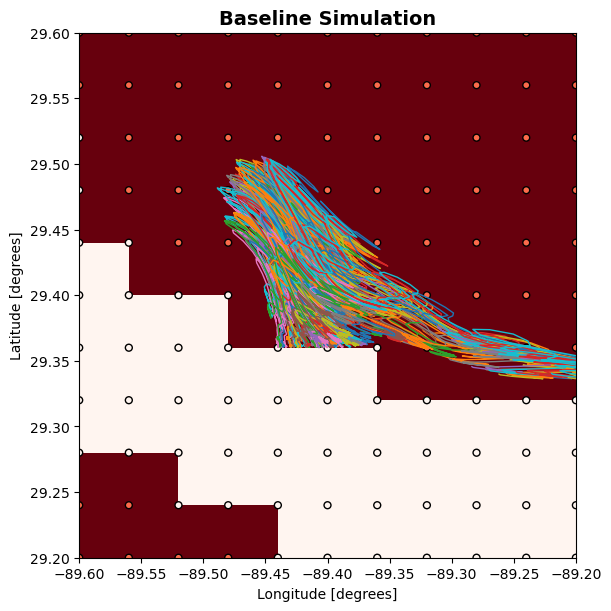

In [23]:
traj_000 = xr.open_dataset(file_000)
ax0 = quick_display_parcels('Baseline Simulation')
ax0.set_xlim(-89.6, -89.2)
ax0.set_ylim(29.2, 29.6)
_ = ax0.plot(traj_000['lon'].T, traj_000['lat'].T, linewidth=1, zorder=1)

#### 1. Add Displacement (ocean velocity, displacement, ~~stokes~~, ~~diffusion~~)

In [5]:
file_100 = outfolder + 'testing_100.zarr'
clear_file(file_100)
_, _ = run_gom_mp(file_100, disp =True, stokes=False, diff = 0.0, indices=indices, testing=True)

INFO: Compiled ArrayPlasticParticleDisplaceAdvectionRK4SetDisplacement ==> C:\Users\pojun\AppData\Local\Temp\parcels-tmp\libfc326694b585df0b8f9cf0063056941b_0.dll
INFO: Output files are stored in testing_output/testing_100.zarr.
100%|██████████| 1800000.0/1800000.0 [01:05<00:00, 27306.94it/s]        


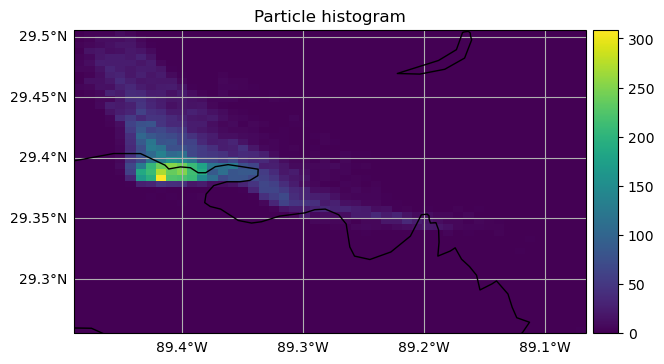

<module 'matplotlib.pyplot' from 'c:\\Users\\pojun\\anaconda3\\envs\\py3_parcels\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [6]:
plotTrajectoriesFile(file_100, mode='hist2d', bins = 50)

c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


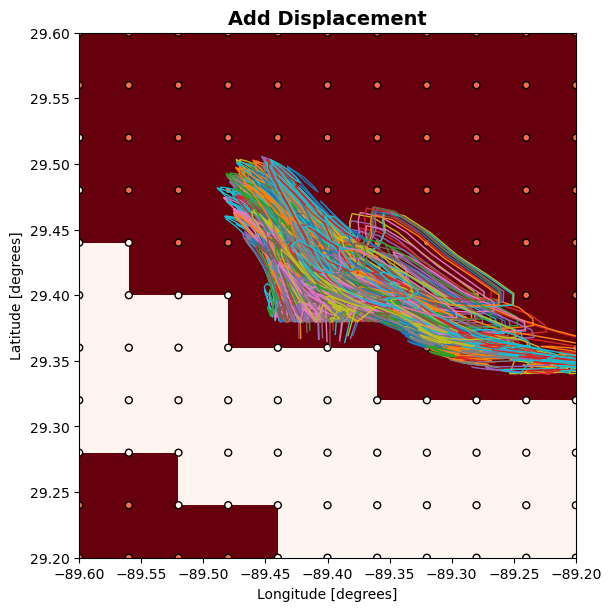

In [25]:
traj_100 = xr.open_dataset(file_100)
ax1 = quick_display_parcels('Add Displacement')
ax1.set_xlim(-89.6, -89.2)
ax1.set_ylim(29.2, 29.6)
_ = ax1.plot(traj_100['lon'].T, traj_100['lat'].T, linewidth=1, zorder=1)

#### 3. Add Stokes (ocean velocity, displacement, stokes, ~~diffusion~~)
Notes: 
* Particles are deleted because the particles are advected outside the testing domain

In [7]:
file_110 = outfolder + 'testing_110.zarr'
clear_file(file_110)
_, _ = run_gom_mp(file_110, disp =True, stokes=True, diff = 0.0, indices=indices, testing=True)

INFO: Compiled ArrayPlasticParticleDisplaceAdvectionRK4SetDisplacement ==> C:\Users\pojun\AppData\Local\Temp\parcels-tmp\lib2841ebe26251edb1c2d2f0c5d8d56274_0.dll
INFO: Output files are stored in testing_output/testing_110.zarr.
 80%|███████▉  | 1432800.000000256/1800000.0 [00:53<00:14, 25025.07it/s]

Particle [213] lost !! (-89.0407 29.2354 0 1.4364e+06)


 80%|████████  | 1443600.000000256/1800000.0 [00:54<00:21, 16871.46it/s]

Particle [261] lost !! (-89.0413 29.2413 0 1.44e+06)
Particle [288] lost !! (-89.041 29.2431 0 1.4436e+06)


 81%|████████  | 1458000.0/1800000.0 [00:55<00:19, 17873.64it/s]        

Particle [258] lost !! (-89.0427 29.2479 0 1.458e+06)
Particle [290] lost !! (-89.0426 29.2385 0 1.458e+06)


 81%|████████  | 1461599.999999744/1800000.0 [00:55<00:21, 15408.65it/s]

Particle [283] lost !! (-89.04 29.2468 0 1.4652e+06)


 82%|████████▏ | 1468800.0/1800000.0 [00:55<00:18, 18000.85it/s]        

Particle [281] lost !! (-89.0402 29.2345 0 1.476e+06)


 89%|████████▉ | 1598400.0/1800000.0 [01:02<00:10, 19768.69it/s]        

Particle [297] lost !! (-89.0468 29.4805 0 1.5984e+06)


 89%|████████▉ | 1605600.000000256/1800000.0 [01:02<00:10, 18331.79it/s]

Particle [208] lost !! (-89.049 29.5469 0 1.602e+06)
Particle [220] lost !! (-89.0415 29.4371 0 1.602e+06)
Particle [236] lost !! (-89.049 29.5469 0 1.602e+06)
Particle [206] lost !! (-89.0424 29.537 0 1.6056e+06)
Particle [210] lost !! (-89.0473 29.4737 0 1.6056e+06)
Particle [212] lost !! (-89.0425 29.5485 0 1.6056e+06)
Particle [214] lost !! (-89.046 29.537 0 1.6056e+06)
Particle [218] lost !! (-89.0428 29.5485 0 1.6056e+06)
Particle [224] lost !! (-89.0502 29.5445 0 1.6056e+06)
Particle [233] lost !! (-89.0466 29.5366 0 1.6056e+06)
Particle [238] lost !! (-89.0425 29.5485 0 1.6056e+06)
Particle [240] lost !! (-89.0515 29.5449 0 1.6056e+06)
Particle [241] lost !! (-89.0424 29.5485 0 1.6056e+06)
Particle [248] lost !! (-89.0524 29.5477 0 1.6056e+06)
Particle [254] lost !! (-89.044 29.5486 0 1.6056e+06)
Particle [257] lost !! (-89.0402 29.5459 0 1.6056e+06)
Particle [269] lost !! (-89.0427 29.5485 0 1.6056e+06)
Particle [273] lost !! (-89.0478 29.549 0 1.6056e+06)
Particle [277] lost 

 89%|████████▉ | 1609200.0/1800000.0 [01:03<00:10, 18134.19it/s]        

Particle [203] lost !! (-89.0525 29.5252 0 1.6092e+06)
Particle [235] lost !! (-89.0489 29.4886 0 1.6092e+06)
Particle [245] lost !! (-89.0402 29.4765 0 1.6092e+06)
Particle [249] lost !! (-89.0441 29.5261 0 1.6092e+06)
Particle [253] lost !! (-89.0506 29.4527 0 1.6092e+06)
Particle [262] lost !! (-89.0487 29.4414 0 1.6092e+06)
Particle [264] lost !! (-89.041 29.5428 0 1.6092e+06)
Particle [267] lost !! (-89.0436 29.5429 0 1.6092e+06)
Particle [299] lost !! (-89.047 29.4619 0 1.6092e+06)


 90%|████████▉ | 1616400.000000256/1800000.0 [01:03<00:10, 16931.00it/s]

Particle [229] lost !! (-89.0435 29.5321 0 1.6128e+06)
Particle [271] lost !! (-89.0459 29.5318 0 1.6128e+06)
Particle [275] lost !! (-89.046 29.5318 0 1.6128e+06)
Particle [284] lost !! (-89.0501 29.5039 0 1.6128e+06)
Particle [285] lost !! (-89.0427 29.5321 0 1.6128e+06)
Particle [289] lost !! (-89.0421 29.4618 0 1.6128e+06)
Particle [298] lost !! (-89.0439 29.4733 0 1.6128e+06)
Particle [200] lost !! (-89.0466 29.4774 0 1.6164e+06)
Particle [230] lost !! (-89.0403 29.4932 0 1.6164e+06)
Particle [231] lost !! (-89.0436 29.4337 0 1.6164e+06)
Particle [263] lost !! (-89.0461 29.5194 0 1.6164e+06)
Particle [268] lost !! (-89.0427 29.42 0 1.6164e+06)
Particle [270] lost !! (-89.0498 29.488 0 1.6164e+06)
Particle [293] lost !! (-89.0402 29.4409 0 1.6164e+06)


 90%|█████████ | 1620000.0/1800000.0 [01:03<00:11, 15782.32it/s]        

Particle [202] lost !! (-89.0417 29.4803 0 1.62e+06)
Particle [205] lost !! (-89.0409 29.4726 0 1.62e+06)
Particle [211] lost !! (-89.0412 29.4836 0 1.62e+06)
Particle [216] lost !! (-89.042 29.4318 0 1.62e+06)
Particle [222] lost !! (-89.0406 29.4824 0 1.62e+06)
Particle [223] lost !! (-89.0469 29.4681 0 1.62e+06)
Particle [226] lost !! (-89.0419 29.4802 0 1.62e+06)
Particle [251] lost !! (-89.0411 29.4311 0 1.62e+06)
Particle [274] lost !! (-89.0471 29.4306 0 1.62e+06)
Particle [278] lost !! (-89.0423 29.4759 0 1.62e+06)
Particle [287] lost !! (-89.0408 29.4572 0 1.62e+06)
Particle [294] lost !! (-89.047 29.4845 0 1.62e+06)


 90%|█████████ | 1623599.999999744/1800000.0 [01:04<00:13, 12771.46it/s]

Particle [234] lost !! (-89.0457 29.4595 0 1.6272e+06)


 91%|█████████ | 1630800.0/1800000.0 [01:04<00:09, 17020.01it/s]        

Particle [209] lost !! (-89.0423 29.4474 0 1.6308e+06)
Particle [272] lost !! (-89.0454 29.4407 0 1.6308e+06)


 91%|█████████ | 1638000.000000256/1800000.0 [01:05<00:10, 15582.76it/s]

Particle [217] lost !! (-89.0447 29.4236 0 1.6344e+06)
Particle [244] lost !! (-89.0446 29.4236 0 1.6344e+06)
Particle [250] lost !! (-89.0445 29.4236 0 1.6344e+06)
Particle [255] lost !! (-89.0438 29.4238 0 1.6344e+06)
Particle [265] lost !! (-89.0439 29.4238 0 1.6344e+06)
Particle [291] lost !! (-89.0422 29.4082 0 1.638e+06)
Particle [292] lost !! (-89.0432 29.4076 0 1.638e+06)


 91%|█████████ | 1641600.0/1800000.0 [01:05<00:10, 15282.36it/s]        

Particle [219] lost !! (-89.0414 29.3883 0 1.6416e+06)
Particle [221] lost !! (-89.044 29.3904 0 1.6416e+06)
Particle [225] lost !! (-89.044 29.3904 0 1.6416e+06)


 92%|█████████▏| 1648800.000000256/1800000.0 [01:05<00:10, 14870.39it/s]

Particle [204] lost !! (-89.0436 29.384 0 1.6452e+06)
Particle [228] lost !! (-89.0405 29.3777 0 1.6452e+06)
Particle [232] lost !! (-89.0404 29.3777 0 1.6452e+06)
Particle [239] lost !! (-89.0404 29.3777 0 1.6452e+06)
Particle [242] lost !! (-89.0405 29.3797 0 1.6452e+06)
Particle [243] lost !! (-89.0403 29.3871 0 1.6452e+06)
Particle [246] lost !! (-89.0405 29.3777 0 1.6452e+06)
Particle [259] lost !! (-89.0404 29.3797 0 1.6452e+06)
Particle [280] lost !! (-89.0405 29.3777 0 1.6452e+06)
Particle [295] lost !! (-89.0404 29.3734 0 1.6452e+06)
Particle [296] lost !! (-89.0404 29.3734 0 1.6452e+06)
Particle [201] lost !! (-89.0435 29.3481 0 1.6488e+06)
Particle [207] lost !! (-89.0429 29.3497 0 1.6488e+06)
Particle [215] lost !! (-89.0445 29.3485 0 1.6488e+06)
Particle [227] lost !! (-89.0445 29.3485 0 1.6488e+06)
Particle [247] lost !! (-89.0432 29.3723 0 1.6488e+06)
Particle [252] lost !! (-89.0424 29.349 0 1.6488e+06)
Particle [260] lost !! (-89.043 29.3485 0 1.6488e+06)
Particle [266

 92%|█████████▏| 1652400.0/1800000.0 [01:06<00:09, 15118.31it/s]        

Particle [237] lost !! (-89.0403 29.3342 0 1.6524e+06)
Particle [256] lost !! (-89.04 29.3355 0 1.6524e+06)
Particle [276] lost !! (-89.0405 29.334 0 1.6524e+06)


 92%|█████████▏| 1655999.999999744/1800000.0 [01:06<00:11, 12134.87it/s]WARNING: ParticleSet is empty on writing as array at time 1.6632e+06
 92%|█████████▏| 1663200.0/1800000.0 [01:06<00:07, 19468.94it/s]        WARNING: ParticleSet is empty on writing as array at time 1.674e+06
 93%|█████████▎| 1674000.0/1800000.0 [01:06<00:03, 31525.98it/s]WARNING: ParticleSet is empty on writing as array at time 1.6848e+06
 94%|█████████▎| 1684800.0/1800000.0 [01:06<00:02, 43061.25it/s]WARNING: ParticleSet is empty on writing as array at time 1.6956e+06
 94%|█████████▍| 1695600.0/1800000.0 [01:07<00:01, 53438.99it/s]WARNING: ParticleSet is empty on writing as array at time 1.7064e+06
 95%|█████████▍| 1706400.0/1800000.0 [01:07<00:01, 60266.96it/s]WARNING: ParticleSet is empty on writing as array at time 1.7172e+06
 95%|█████████▌| 1717200.0/1800000.0 [01:07<00:01, 66541.57it/s]WARNING: ParticleSet is empty on writing as array at time 1.728e+06
 96%|█████████▌| 1728000.0/1800000.0 [01:07<00:00, 7324

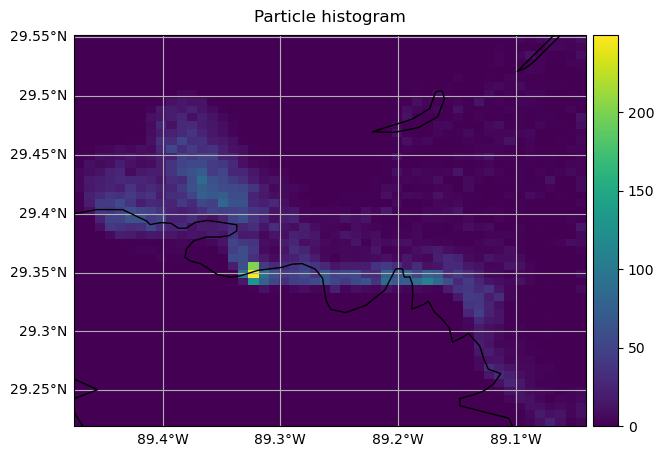

<module 'matplotlib.pyplot' from 'c:\\Users\\pojun\\anaconda3\\envs\\py3_parcels\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [8]:
plotTrajectoriesFile(file_110, mode='hist2d', bins = 50)

c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


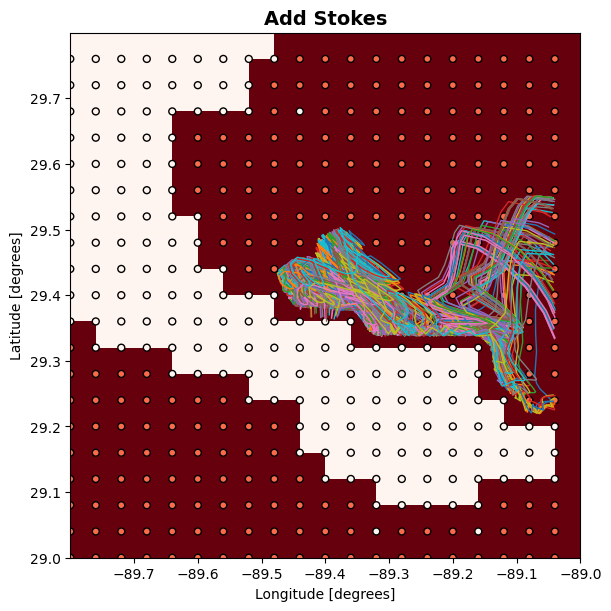

In [27]:
traj_110 = xr.open_dataset(file_110)
ax2 = quick_display_parcels('Add Stokes')
_ = ax2.plot(traj_110['lon'].T, traj_110['lat'].T, linewidth=1, zorder=1)

#### 4. Add Diffusion (ocean velocity, displacement, stokes, diffusion)
Notes: 
* Particles are deleted because the particles are advected outside the testing domain
* Smagorinsky Constant = 0.1

In [9]:
file_111 = outfolder + 'testing_111.zarr'
clear_file(file_111)
_, _ = run_gom_mp(file_111, disp =True, stokes=True, diff = 0.1, indices=indices, testing=True)

INFO: Compiled ArrayPlasticParticleDisplaceAdvectionRK4SmagDiffSetDisplacement ==> C:\Users\pojun\AppData\Local\Temp\parcels-tmp\lib5c17def1fe432deb8ed3ed7401b7a89f_0.dll
INFO: Output files are stored in testing_output/testing_111.zarr.
 60%|██████    | 1080000.0/1800000.0 [00:39<00:31, 22862.72it/s]       

Particle [309] lost !! (-89.0425 29.3233 0 1.08e+06)


 60%|██████    | 1087200.000000256/1800000.0 [00:39<00:35, 20082.57it/s]

Particle [377] lost !! (-89.0494 29.2545 0 1.0836e+06)
Particle [358] lost !! (-89.0512 29.2947 0 1.0872e+06)


 61%|██████    | 1090800.0/1800000.0 [00:39<00:37, 18999.87it/s]        

Particle [313] lost !! (-89.0405 29.2795 0 1.0908e+06)
Particle [397] lost !! (-89.046 29.263 0 1.0908e+06)


 61%|██████    | 1101600.0/1800000.0 [00:40<00:37, 18660.20it/s]        

Particle [328] lost !! (-89.0413 29.2574 0 1.1016e+06)
Particle [351] lost !! (-89.061 29.234 0 1.1016e+06)
Particle [370] lost !! (-89.0414 29.2872 0 1.1016e+06)
Particle [374] lost !! (-89.0539 29.2313 0 1.1016e+06)


 62%|██████▏   | 1108799.999999744/1800000.0 [00:41<00:41, 16527.90it/s]

Particle [321] lost !! (-89.051 29.3071 0 1.1052e+06)
Particle [345] lost !! (-89.0524 29.2733 0 1.1052e+06)
Particle [357] lost !! (-89.0523 29.208 0 1.1052e+06)
Particle [359] lost !! (-89.044 29.2431 0 1.1052e+06)
Particle [349] lost !! (-89.0427 29.2544 0 1.1088e+06)
Particle [364] lost !! (-89.0422 29.2704 0 1.1088e+06)


 62%|██████▏   | 1112400.0/1800000.0 [00:41<00:46, 14820.61it/s]        

Particle [390] lost !! (-89.0467 29.2356 0 1.1124e+06)


 62%|██████▏   | 1119600.000000256/1800000.0 [00:41<00:47, 14346.92it/s]

Particle [363] lost !! (-89.0408 29.2456 0 1.116e+06)
Particle [369] lost !! (-89.05 29.3182 0 1.116e+06)
Particle [388] lost !! (-89.0493 29.2759 0 1.116e+06)
Particle [312] lost !! (-89.0502 29.2758 0 1.1196e+06)
Particle [314] lost !! (-89.0479 29.2163 0 1.1196e+06)


 62%|██████▏   | 1123200.0/1800000.0 [00:42<00:45, 14789.65it/s]        

Particle [340] lost !! (-89.0404 29.2659 0 1.1232e+06)


 63%|██████▎   | 1134000.0/1800000.0 [00:42<00:37, 17758.26it/s]        

Particle [323] lost !! (-89.046 29.231 0 1.134e+06)
Particle [389] lost !! (-89.0495 29.2163 0 1.134e+06)


 64%|██████▎   | 1144800.0/1800000.0 [00:43<00:33, 19676.70it/s]        

Particle [331] lost !! (-89.0494 29.2527 0 1.1448e+06)


 64%|██████▍   | 1148399.999999744/1800000.0 [00:43<00:44, 14702.32it/s]

Particle [372] lost !! (-89.0536 29.2128 0 1.152e+06)


 64%|██████▍   | 1155600.0/1800000.0 [00:44<00:35, 18016.38it/s]        

Particle [317] lost !! (-89.0505 29.2165 0 1.1556e+06)


 65%|██████▍   | 1166400.0/1800000.0 [00:44<00:35, 18029.67it/s]        

Particle [398] lost !! (-89.0411 29.2537 0 1.1664e+06)


 65%|██████▌   | 1173600.000000256/1800000.0 [00:45<00:39, 16034.95it/s]

Particle [392] lost !! (-89.0505 29.2148 0 1.17e+06)
Particle [371] lost !! (-89.0435 29.2298 0 1.1736e+06)


 65%|██████▌   | 1177200.0/1800000.0 [00:45<00:40, 15282.17it/s]        

Particle [320] lost !! (-89.0482 29.2405 0 1.1772e+06)


 66%|██████▌   | 1180799.999999744/1800000.0 [00:46<00:48, 12701.36it/s]

Particle [383] lost !! (-89.0502 29.2065 0 1.1844e+06)


 67%|██████▋   | 1198800.0/1800000.0 [00:46<00:33, 17860.79it/s]        

Particle [330] lost !! (-89.0477 29.2165 0 1.206e+06)
Particle [366] lost !! (-89.0436 29.2242 0 1.206e+06)


 67%|██████▋   | 1209600.0/1800000.0 [00:47<00:33, 17860.34it/s]

Particle [315] lost !! (-89.0465 29.2359 0 1.2096e+06)


 68%|██████▊   | 1220400.0/1800000.0 [00:48<00:30, 18986.87it/s]        

Particle [308] lost !! (-89.0532 29.2159 0 1.2204e+06)


 68%|██████▊   | 1227599.999999744/1800000.0 [00:48<00:32, 17768.01it/s]

Particle [334] lost !! (-89.0437 29.2247 0 1.224e+06)


 68%|██████▊   | 1231200.0/1800000.0 [00:48<00:31, 18059.49it/s]        

Particle [335] lost !! (-89.0539 29.2191 0 1.2348e+06)


 69%|██████▉   | 1238399.999999744/1800000.0 [00:49<00:30, 18385.12it/s]

Particle [304] lost !! (-89.0403 29.2322 0 1.2384e+06)


 69%|██████▉   | 1242000.0/1800000.0 [00:49<00:32, 17054.70it/s]        

Particle [376] lost !! (-89.0478 29.2177 0 1.242e+06)


 69%|██████▉   | 1249199.999999744/1800000.0 [00:49<00:34, 16094.64it/s]

Particle [333] lost !! (-89.0513 29.2381 0 1.2456e+06)
Particle [365] lost !! (-89.0452 29.2269 0 1.2492e+06)


 70%|██████▉   | 1252800.0/1800000.0 [00:50<00:42, 12888.53it/s]        

Particle [394] lost !! (-89.0404 29.2221 0 1.2564e+06)


 70%|███████   | 1263600.0/1800000.0 [00:50<00:34, 15354.91it/s]        

Particle [355] lost !! (-89.0549 29.211 0 1.2636e+06)


 70%|███████   | 1267199.999999744/1800000.0 [00:51<00:42, 12568.23it/s]

Particle [344] lost !! (-89.0433 29.246 0 1.2708e+06)
Particle [361] lost !! (-89.0463 29.2497 0 1.2708e+06)


 71%|███████   | 1274400.0/1800000.0 [00:51<00:33, 15814.96it/s]        

Particle [310] lost !! (-89.0487 29.2188 0 1.2744e+06)
Particle [395] lost !! (-89.0447 29.2299 0 1.2744e+06)


 71%|███████   | 1281600.000000256/1800000.0 [00:52<00:33, 15440.01it/s]

Particle [342] lost !! (-89.042 29.2196 0 1.278e+06)


 75%|███████▌  | 1350000.0/1800000.0 [00:55<00:21, 21037.27it/s]        

Particle [336] lost !! (-89.0438 29.2155 0 1.3572e+06)


 76%|███████▌  | 1360800.0/1800000.0 [00:56<00:22, 19923.01it/s]

Particle [327] lost !! (-89.0466 29.2184 0 1.368e+06)


 76%|███████▌  | 1371600.0/1800000.0 [00:56<00:22, 19275.36it/s]

Particle [352] lost !! (-89.0541 29.2139 0 1.3788e+06)


 77%|███████▋  | 1382400.0/1800000.0 [00:57<00:22, 18579.61it/s]

Particle [353] lost !! (-89.0453 29.232 0 1.386e+06)


 77%|███████▋  | 1393200.0/1800000.0 [00:57<00:22, 18110.82it/s]        

Particle [338] lost !! (-89.041 29.2292 0 1.3968e+06)


 80%|████████  | 1447200.0/1800000.0 [01:00<00:16, 21487.72it/s]        

Particle [337] lost !! (-89.0436 29.2774 0 1.4508e+06)


 81%|████████  | 1454399.999999744/1800000.0 [01:01<00:19, 17532.49it/s]

Particle [302] lost !! (-89.0491 29.2703 0 1.4544e+06)
Particle [347] lost !! (-89.0509 29.2517 0 1.4544e+06)
Particle [382] lost !! (-89.0512 29.2645 0 1.4544e+06)


 82%|████████▏ | 1468800.0/1800000.0 [01:02<00:20, 16495.40it/s]        

Particle [399] lost !! (-89.0511 29.2668 0 1.4688e+06)


 82%|████████▏ | 1476000.000000256/1800000.0 [01:02<00:20, 16157.90it/s]

Particle [316] lost !! (-89.0416 29.2328 0 1.4724e+06)


 87%|████████▋ | 1566000.0/1800000.0 [01:06<00:11, 21208.53it/s]        

Particle [385] lost !! (-89.0504 29.5283 0 1.5696e+06)


 87%|████████▋ | 1573199.999999744/1800000.0 [01:07<00:11, 20427.04it/s]

Particle [375] lost !! (-89.0501 29.5335 0 1.5732e+06)
Particle [381] lost !! (-89.0552 29.4955 0 1.5732e+06)


 88%|████████▊ | 1576800.0/1800000.0 [01:07<00:11, 19153.38it/s]        

Particle [303] lost !! (-89.0515 29.4747 0 1.5768e+06)
Particle [343] lost !! (-89.0515 29.5371 0 1.5768e+06)
Particle [350] lost !! (-89.0428 29.5296 0 1.5768e+06)
Particle [373] lost !! (-89.0459 29.4744 0 1.5768e+06)


 88%|████████▊ | 1587600.0/1800000.0 [01:08<00:11, 19109.88it/s]        

Particle [367] lost !! (-89.0568 29.5264 0 1.5948e+06)


 89%|████████▉ | 1598400.0/1800000.0 [01:08<00:11, 18068.43it/s]

Particle [307] lost !! (-89.0497 29.5438 0 1.5984e+06)
Particle [332] lost !! (-89.0459 29.5521 0 1.5984e+06)


 89%|████████▉ | 1605600.000000256/1800000.0 [01:09<00:11, 16419.23it/s]

Particle [378] lost !! (-89.0479 29.4997 0 1.602e+06)
Particle [300] lost !! (-89.0554 29.4405 0 1.6056e+06)
Particle [319] lost !! (-89.0526 29.5167 0 1.6056e+06)
Particle [360] lost !! (-89.0497 29.5353 0 1.6056e+06)


 89%|████████▉ | 1609200.0/1800000.0 [01:09<00:11, 16597.57it/s]        

Particle [339] lost !! (-89.0555 29.4344 0 1.6092e+06)


 90%|████████▉ | 1616400.000000256/1800000.0 [01:10<00:11, 16336.54it/s]

Particle [305] lost !! (-89.0499 29.4381 0 1.6128e+06)
Particle [356] lost !! (-89.0491 29.5518 0 1.6128e+06)
Particle [387] lost !! (-89.0512 29.4736 0 1.6128e+06)
Particle [326] lost !! (-89.0432 29.3991 0 1.6164e+06)
Particle [393] lost !! (-89.0559 29.5394 0 1.6164e+06)


 90%|█████████ | 1620000.0/1800000.0 [01:10<00:12, 14594.18it/s]        

Particle [362] lost !! (-89.0421 29.3492 0 1.62e+06)


 91%|█████████ | 1630800.0/1800000.0 [01:11<00:10, 16184.54it/s]        

Particle [391] lost !! (-89.0402 29.5112 0 1.6272e+06)
Particle [396] lost !! (-89.0401 29.3205 0 1.6308e+06)


 91%|█████████ | 1634399.999999744/1800000.0 [01:11<00:12, 13487.84it/s]

Particle [354] lost !! (-89.0425 29.4093 0 1.638e+06)


 91%|█████████ | 1641600.0/1800000.0 [01:11<00:09, 16212.74it/s]        

Particle [324] lost !! (-89.0504 29.4311 0 1.6416e+06)


 94%|█████████▎| 1684800.0/1800000.0 [01:14<00:06, 18610.54it/s]        

Particle [348] lost !! (-89.0537 29.247 0 1.6848e+06)


 94%|█████████▍| 1695600.0/1800000.0 [01:14<00:05, 19064.62it/s]        

Particle [322] lost !! (-89.0508 29.2542 0 1.6992e+06)


 95%|█████████▌| 1717200.0/1800000.0 [01:16<00:04, 18176.43it/s]        

Particle [368] lost !! (-89.0474 29.2563 0 1.7172e+06)


100%|██████████| 1800000.0/1800000.0 [01:20<00:00, 22361.00it/s]        


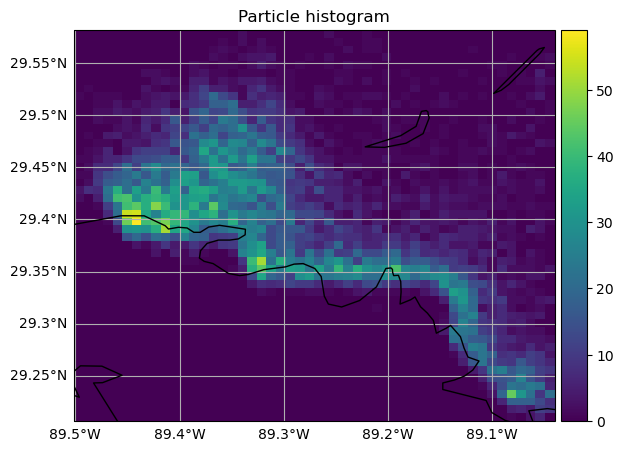

<module 'matplotlib.pyplot' from 'c:\\Users\\pojun\\anaconda3\\envs\\py3_parcels\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [10]:
plotTrajectoriesFile(file_111, mode='hist2d', bins = 50)

c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


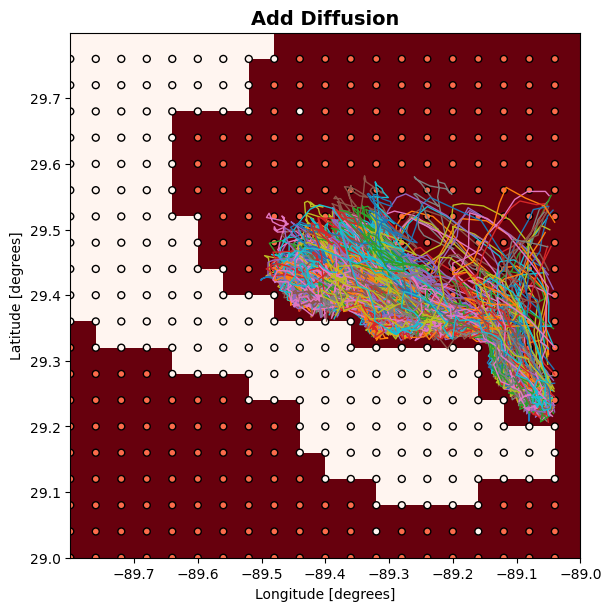

In [28]:
traj_111 = xr.open_dataset(file_111)
ax3 = quick_display_parcels('Add Diffusion')
_ = ax3.plot(traj_111['lon'].T, traj_111['lat'].T, linewidth=1, zorder=1)

In [39]:
plotTrajectoriesFile(file_111, mode='movie2d_notebook')

#### TEST INVERSE PROBLEM RELEASE

In [50]:
# Correct Plotting
gom_masks = xr.open_dataset('data/gom_masks_w_inputs.nc')

lon_min, lon_max, lat_min, lat_max = -90.2, -88.64, 28.6, 30.16
idxs = np.where((gom_masks.Latitude >= lat_min) & (gom_masks.Latitude <= lat_max) & (gom_masks.Longitude >= lon_min) & (gom_masks.Longitude <= lon_max))

ti_latmin, ti_latmax,ti_lonmin, ti_lonmax = idxs[0][0], idxs[0][-1] + 4, idxs[1][0], idxs[1][-1]

# Velocity nodes
lon_vals, lat_vals = np.meshgrid(gom_masks['Longitude'], gom_masks['Latitude'])
lons_plot = lon_vals[ti_latmin:ti_latmax,ti_lonmin:ti_lonmax]
lats_plot = lat_vals[ti_latmin:ti_latmax,ti_lonmin:ti_lonmax]

landmask = gom_masks.landmask

# Centers of the gridcells formed by 4 nodes = velocity nodes + 0.5 dx
x = gom_masks['Longitude'][:-1]+np.diff(gom_masks['Longitude'])/2
y = gom_masks['Latitude'][:-1]+np.diff(gom_masks['Latitude'])/2
lon_centers, lat_centers = np.meshgrid(x, y)

# Interpolate the landmask to the cell centers - only cells with 4 neighbouring land points will be land
fl = interpolate.interp2d(gom_masks['Longitude'],gom_masks['Latitude'],landmask)
l_centers = fl(lon_centers[0,:],lat_centers[:,0])  
lmask = np.ma.masked_values(l_centers,1) # land when interpolated value == 1
    
def quick_display_parcels(title = 'No Title'):
    fig = plt.figure(figsize=(6,6), constrained_layout=True)
    ax0 = fig.add_subplot()
    ax0.set_ylabel('Latitude [degrees]')
    ax0.set_xlabel('Longitude [degrees]')
    ax0.set_title(title, fontsize=14, fontweight = 'bold')

    land = ax0.pcolormesh(lon_vals[ti_latmin:ti_latmax+1,ti_lonmin:ti_lonmax+1], lat_vals[ti_latmin:ti_latmax+1,ti_lonmin:ti_lonmax+1], lmask.mask[ti_latmin:ti_latmax,ti_lonmin:ti_lonmax],cmap='Reds_r')
    ax0.scatter(lons_plot, lats_plot, c=landmask[ti_latmin:ti_latmax,ti_lonmin:ti_lonmax],s=25,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')
    return ax0

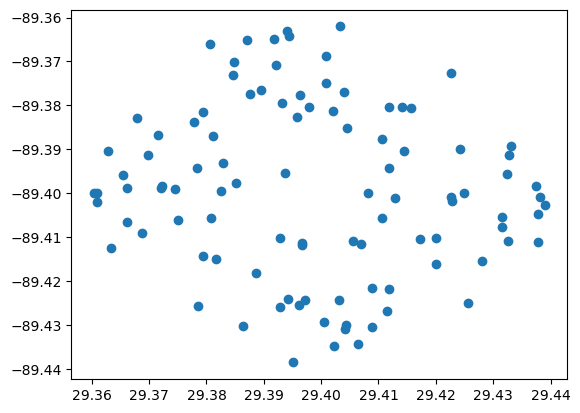

In [48]:
%run -i gom_mp_kernels.py
%run -i run_gom_mp.py

rand_lats, rand_lons, _ = test_2_pset(gom_masks)

plt.scatter(rand_lats[:100], rand_lons[:100])

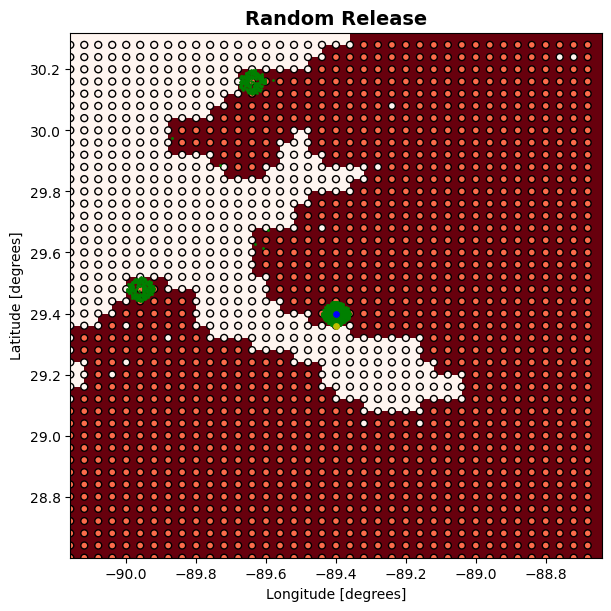

In [52]:

axr = quick_display_parcels('Random Release')
releases = axr.scatter(rand_lons, rand_lats, c = 'g', s=1, zorder=1)
center = axr.scatter(tc_lon, tc_lat, c = 'b', s=15, zorder=2)
center_below = axr.scatter(tc_lon, tc_lat - CELL_SIZE, c = 'y', s=15, zorder=2)